In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! kaggle datasets download -d teykaicong/iamondb-handwriting-dataset

Dataset URL: https://www.kaggle.com/datasets/teykaicong/iamondb-handwriting-dataset
License(s): unknown
100% 786M/788M [00:44<00:00, 23.5MB/s]
100% 788M/788M [00:44<00:00, 18.7MB/s]


In [ ]:
!cp iamondb-handwriting-dataset.zip /content/drive/MyDrive/

In [ ]:
from zipfile import ZipFile

# Path to the zip file
file_name = "/content/drive/MyDrive/iamondb-handwriting-dataset.zip"

# Path where the extracted files will be saved
extract_to_path = "/content/drive/MyDrive/"

# Extract the files
with ZipFile(file_name, 'r') as zip:
    zip.extractall(extract_to_path)
    print(f'Files extracted successfully to {extract_to_path}')


Files extracted successfully to /content/drive/MyDrive/


In [ ]:
import tarfile

# Specify the path to the words.tgz file
file_path = "/content/drive/MyDrive/words.tgz"

# Specify the path to the extraction folder
extract_path = "/content/drive/MyDrive/words_data"

# Open the tar file
with tarfile.open(file_path, "r:gz") as tar:
    # Extract all contents to the extraction folder
    tar.extractall(path=extract_path)

print(f"Successfully extracted {file_path} to {extract_path}")

In [ ]:
import os
import shutil

# Define the source directory and the destination directory
source_dir = "/content/drive/MyDrive/words_data"
destination_dir = "/content/drive/MyDrive/all_png_files"  # Create this directory if it doesn't exist

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through all files and subdirectories within the source directory
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(".png"):  # Check if the file is a PNG file
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_dir, file)

            # Move the file to the destination directory
            shutil.move(source_path, destination_path)

print("All PNG files have been moved to the 'all_png_files' directory.")

All PNG files have been moved to the 'all_png_files' directory.


In [ ]:
import os

def count_files_in_directory(directory_path):
  """Counts the number of files in a directory.

  Args:
    directory_path: The path to the directory.

  Returns:
    The number of files in the directory.
  """

  file_count = 0
  for _, _, files in os.walk(directory_path):
    file_count += len(files)
  return file_count

# Example usage:
directory_path = '/content/drive/MyDrive/all_png_files'  # Replace with your directory path
file_count = count_files_in_directory(directory_path)
print(f"total number of images {file_count}")

total number of images 9756


In [ ]:
import numpy as np
 #Fundamental package for numerical computing in Python.
import cv2
# (OpenCV): Library for computer vision tasks, such as image processing and manipulation
import pandas as pd
#Data manipulation and analysis library, often used for handling tabular data.
import string

import matplotlib.pyplot as plt
#Plotting library for visualizing data.

import os

#Keras is a high-level neural networks API, and the following modules are imported for deep learning model development:

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#Scikit-learn is used for preprocessing and splitting data:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
with open('/content/drive/MyDrive/words_new.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [ ]:
#labelling encoding of text

max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for i in (txt):
        dig_lst.append(char_list.index(i))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
images = []
labels = []

RECORDS_COUNT = 8000

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []


def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

#     _, img = cv2.threshold(img,
#                            128,
#                            255,
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
      word_id = splits[0]  # Extract the word ID
      word = "".join(splits[8:])  # Combine the relevant parts into the word (if needed)


# Construct the file path based on the directory structure
      filepath = f'/content/drive/MyDrive/all_png_files/{word_id}.png'

        # processing on image
      img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
      try:
            img = process_image(img)
      except:
            continue

        # processing on label
      try:
            label = encode_to_labels(word)
      except:
            continue

      if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
      else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

    if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((2454, 15), (274, 15))

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

train_images.shape

(2454, 32, 128, 1)

In [ ]:
from tensorflow.keras.backend import ctc_batch_cost
from tensorflow.keras.layers import Lambda
import tensorflow as tf

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

# Specify output_shape for the Lambda layer
squeezed = Lambda(lambda x: tf.squeeze(x, 1), output_shape=(31, 512))(conv_7)
# We know the output shape after squeezing will be (None, 31, 512)
# We provide (31, 512) as output_shape, excluding the batch dimension (None).

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)


act_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 128, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 32, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 32, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 32, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 32, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 32, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 32, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 4, 32, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 32, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 32, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 1, 31, 512)          │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 31, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 31, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 31, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31, 79)              │          40,527 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
!pip install  keras_tqdm
from keras_tqdm import TQDMNotebookCallback

#Purpose: It provides a progress bar during Keras model training, showing the training status for each
#epoch and batch in an easy-to-read format.

In [73]:
batch_size = 4
epochs = 10
e = str(epochs)
optimizer_name = 'sgd'

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath=filepath = "/content/drive/MyDrive/Model/{}o-{}r-{}e-{}t-{}v.keras".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(len(train_images)),
                                          str(len(valid_images)))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)



Epoch 1/10

Epoch 1: val_loss improved from inf to 6.94125, saving model to /content/drive/MyDrive/Model/sgdo-8000r-10e-2454t-274v.keras
614/614 - 17s - 28ms/step - accuracy: 0.9976 - loss: 0.0214 - val_accuracy: 0.4307 - val_loss: 6.9412
Epoch 2/10

Epoch 2: val_loss did not improve from 6.94125
614/614 - 14s - 22ms/step - accuracy: 0.9967 - loss: 0.0220 - val_accuracy: 0.4380 - val_loss: 6.9676
Epoch 3/10

Epoch 3: val_loss improved from 6.94125 to 6.93340, saving model to /content/drive/MyDrive/Model/sgdo-8000r-10e-2454t-274v.keras
614/614 - 21s - 34ms/step - accuracy: 0.9980 - loss: 0.0192 - val_accuracy: 0.4343 - val_loss: 6.9334
Epoch 4/10

Epoch 4: val_loss did not improve from 6.93340
614/614 - 20s - 33ms/step - accuracy: 0.9988 - loss: 0.0175 - val_accuracy: 0.4270 - val_loss: 6.9605
Epoch 5/10

Epoch 5: val_loss did not improve from 6.93340
614/614 - 20s - 33ms/step - accuracy: 0.9984 - loss: 0.0163 - val_accuracy: 0.4197 - val_loss: 7.1353
Epoch 6/10

Epoch 6: val_loss did n

In [75]:
!pip install python-levenshtein

In [78]:
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

# use CTC decoder
decoded = tf.keras.backend.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = tf.keras.backend.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
jaro : 0.8463179696756333
ratio: 0.8002582752450728


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
original_text =   "
predicted text = "

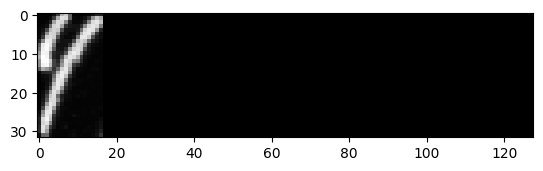



original_text =   after
predicted text = after

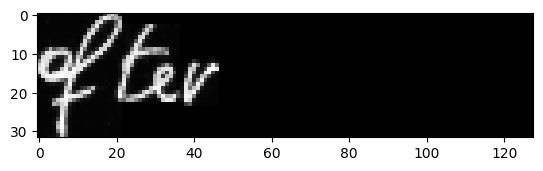



original_text =   addresses
predicted text = addresses

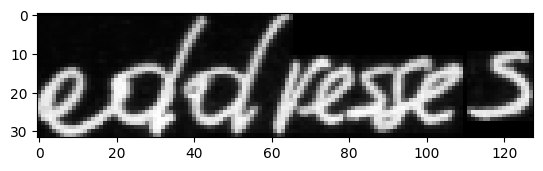



original_text =   by
predicted text = by

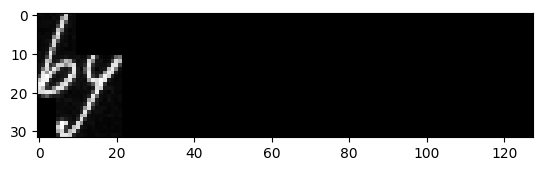



original_text =   Comrades
predicted text = Comrades

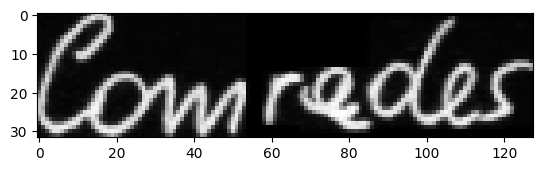



original_text =   Krobo
predicted text = Krobo

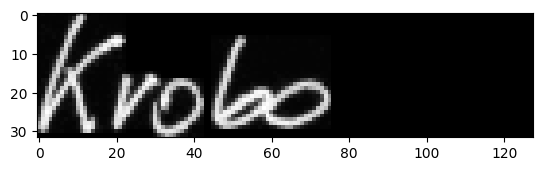



original_text =   Edusei
predicted text = Edusei

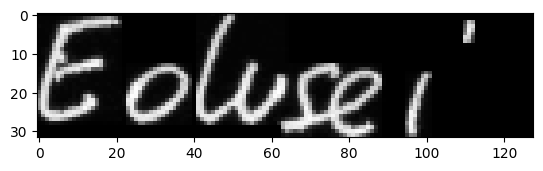



original_text =   ,
predicted text = ,

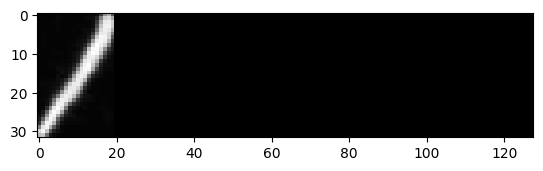



original_text =   Tawia
predicted text = Tawia

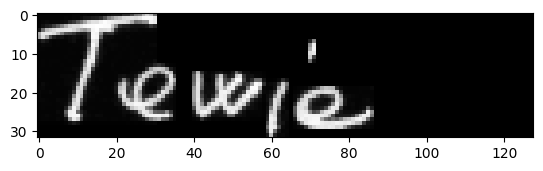



original_text =   Adamafio
predicted text = Adamafio

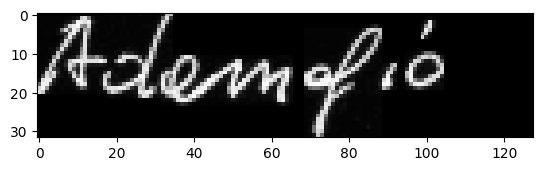



original_text =   ,
predicted text = ,

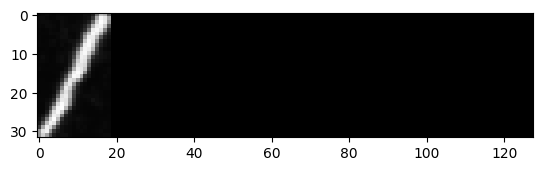



original_text =   and
predicted text = and

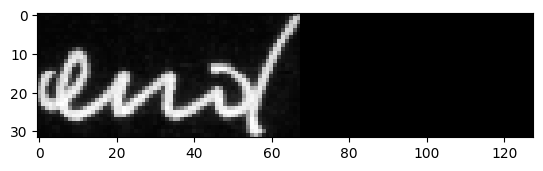



original_text =   others
predicted text = others

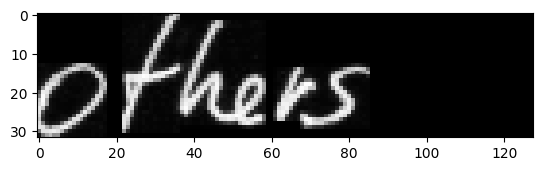



original_text =   .
predicted text = .

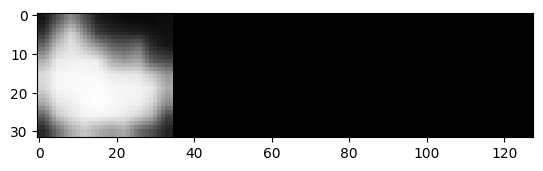



original_text =   Strong
predicted text = Strong

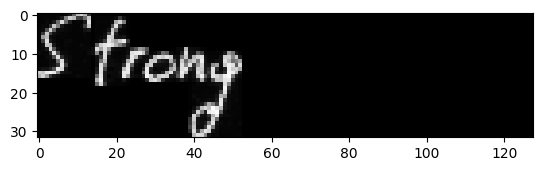



original_text =   deeds
predicted text = deeds

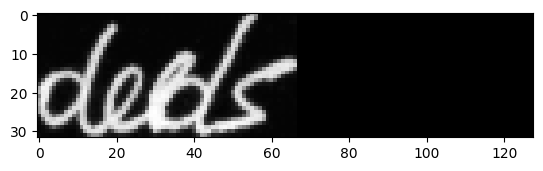



original_text =   followed
predicted text = followed

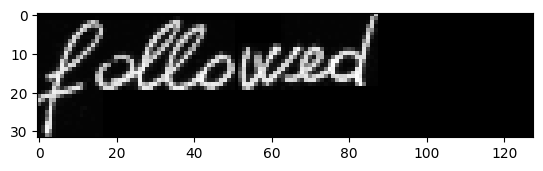



original_text =   strong
predicted text = strong

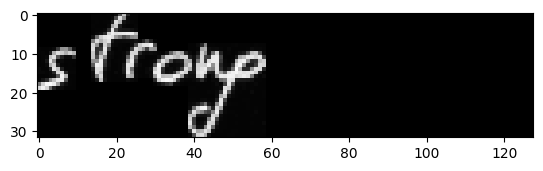



original_text =   words
predicted text = words

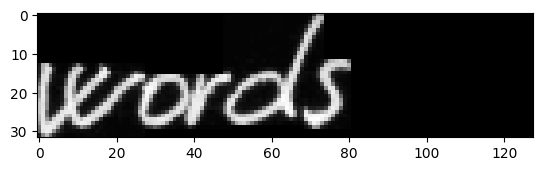



original_text =   .
predicted text = .

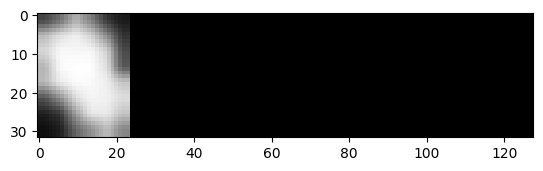



original_text =   Takoradi
predicted text = Takoradi

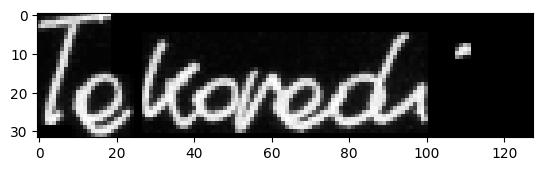



original_text =   the
predicted text = the

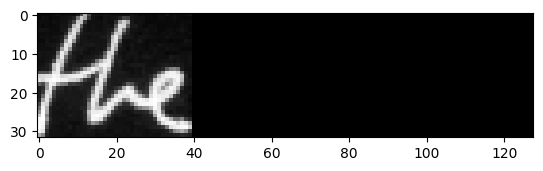



original_text =   Government
predicted text = Government

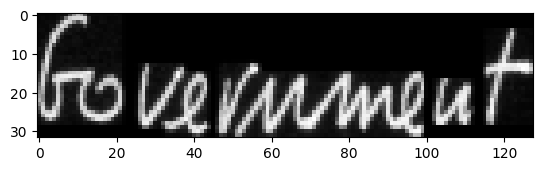



original_text =   adequate
predicted text = adequate

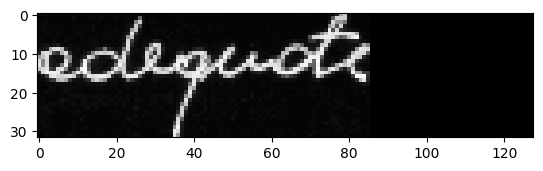



original_text =   power
predicted text = power

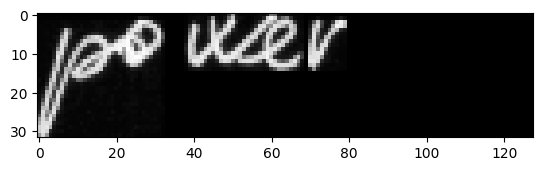



original_text =   to
predicted text = to

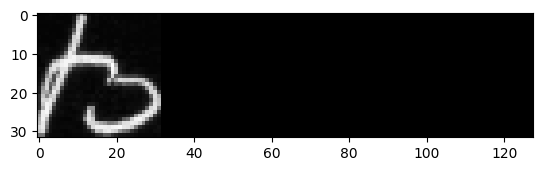



original_text =   maintain
predicted text = maintain

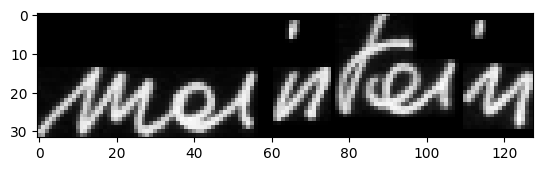



original_text =   all
predicted text = all

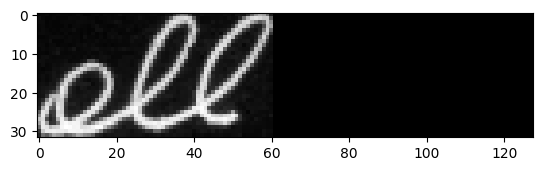



original_text =   services
predicted text = services

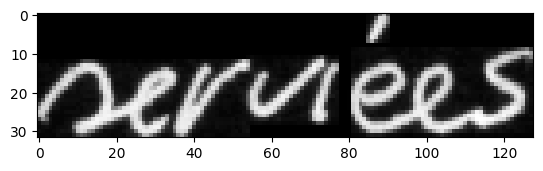



original_text =   and
predicted text = and

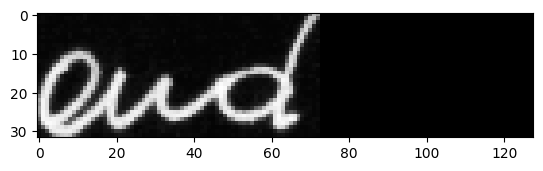



original_text =   ensure
predicted text = ensure

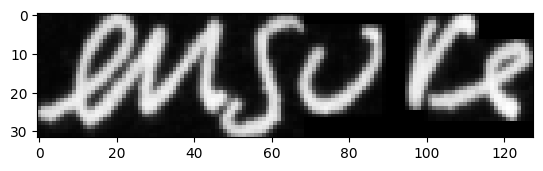



original_text =   food
predicted text = food

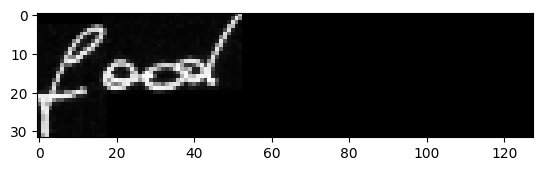



original_text =   supplies
predicted text = supplies

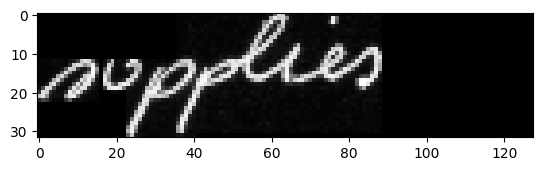



original_text =   .
predicted text = .

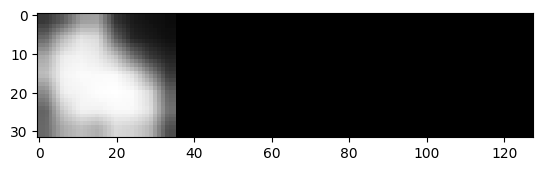



original_text =   Thus
predicted text = Thus

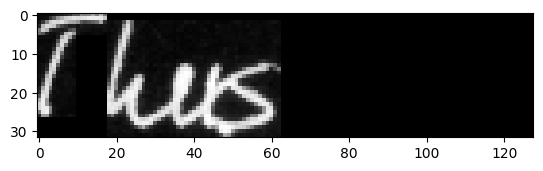



original_text =   it
predicted text = it

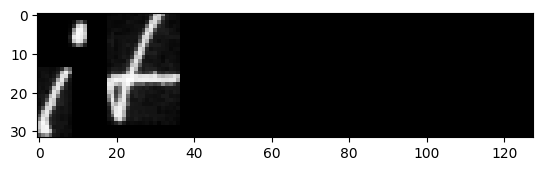



original_text =   becomes
predicted text = becomes

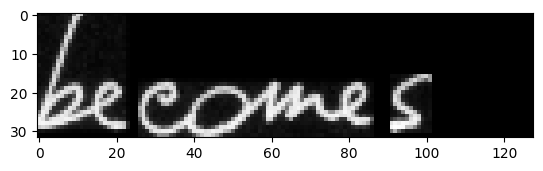



original_text =   offence
predicted text = offence

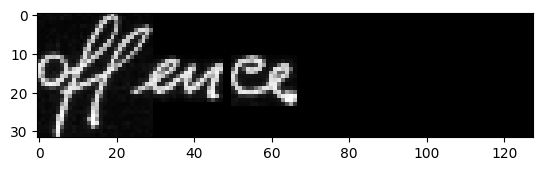



original_text =   punishable
predicted text = punishable

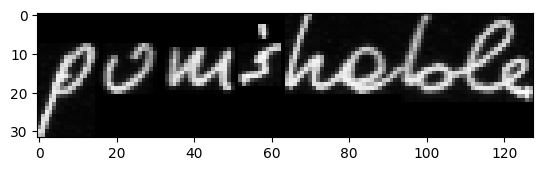



original_text =   with
predicted text = with

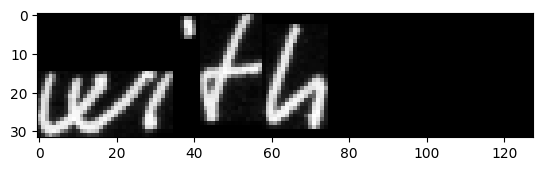



original_text =   imprisonment
predicted text = imprisonment

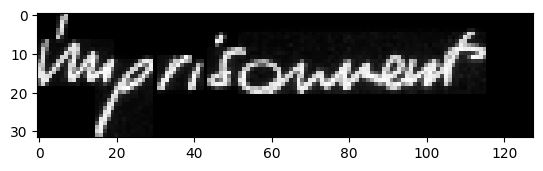



original_text =   for
predicted text = for

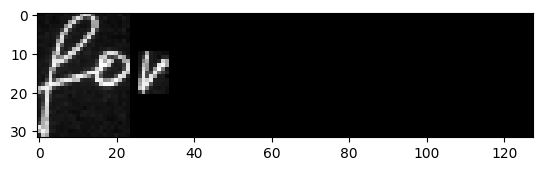



original_text =   anyone
predicted text = anyone

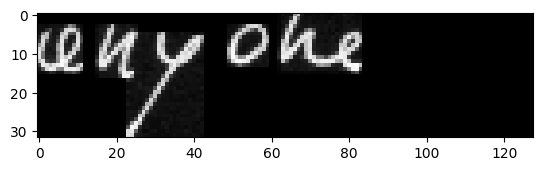



original_text =   who
predicted text = who

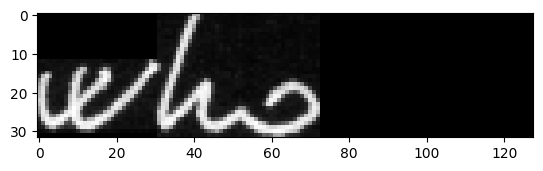



original_text =   "
predicted text = "

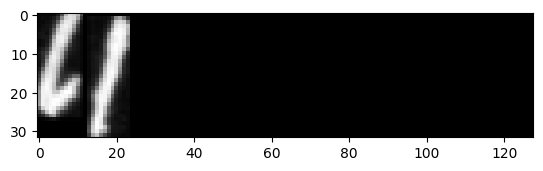



original_text =   publishes
predicted text = publishes

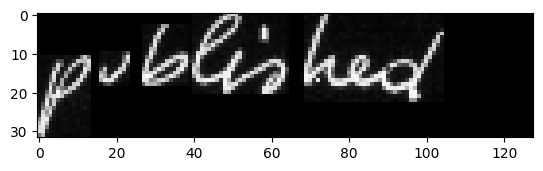



original_text =   report
predicted text = report

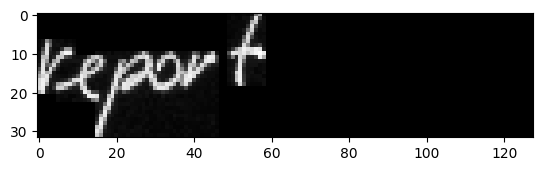



original_text =   likely
predicted text = likely

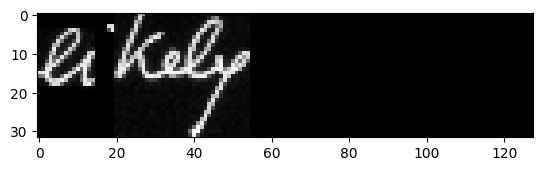



original_text =   to
predicted text = to

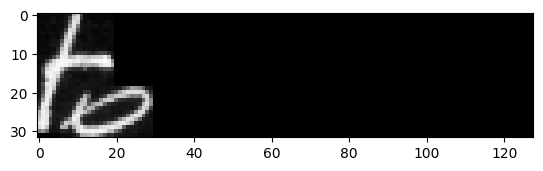



original_text =   cause
predicted text = cause

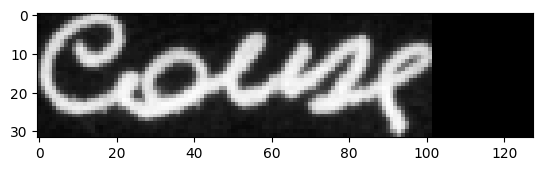



original_text =   on
predicted text = on

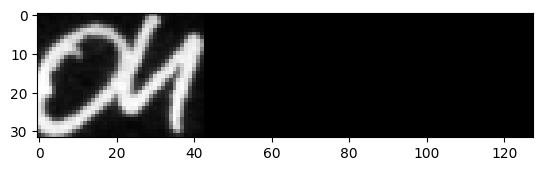



original_text =   anyone
predicted text = anyone

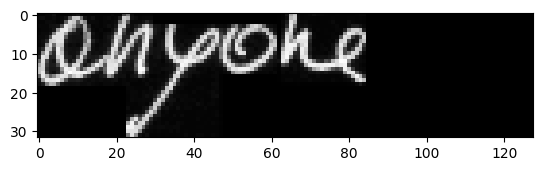



original_text =   convicted
predicted text = convicted

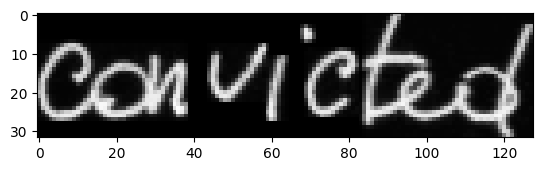



original_text =   of
predicted text = of

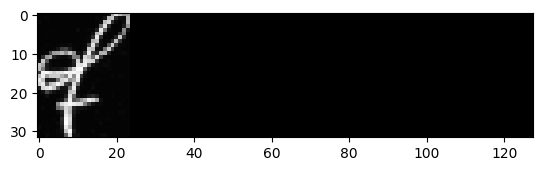



original_text =   sabotage
predicted text = sabotage

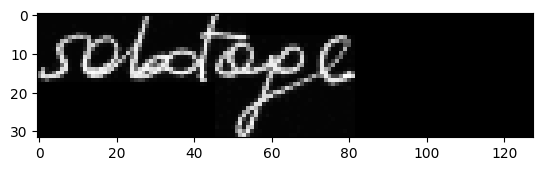



original_text =   .
predicted text = .

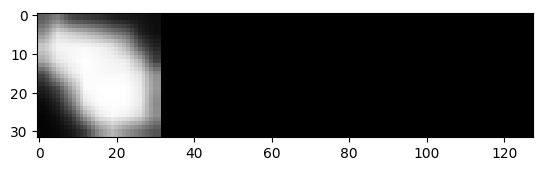



original_text =   These
predicted text = These

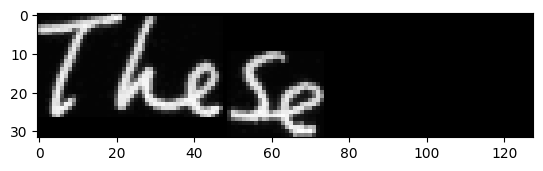



original_text =   stern
predicted text = stern

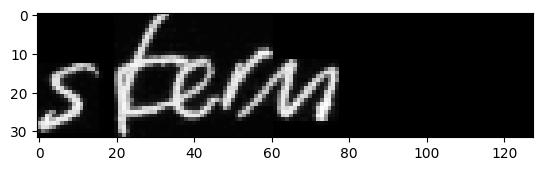



original_text =   had
predicted text = had

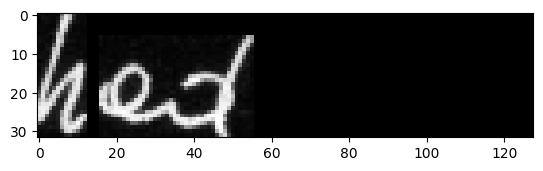



original_text =   the
predicted text = the

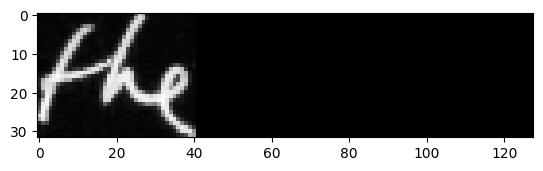



original_text =   desired
predicted text = desired

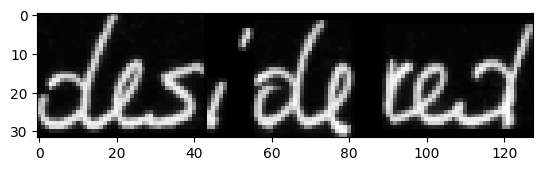



original_text =   effect
predicted text = effect

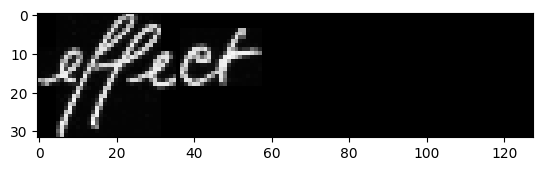



original_text =   today
predicted text = today

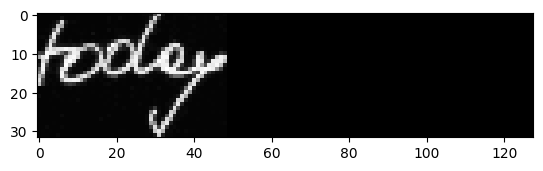



original_text =   at
predicted text = at

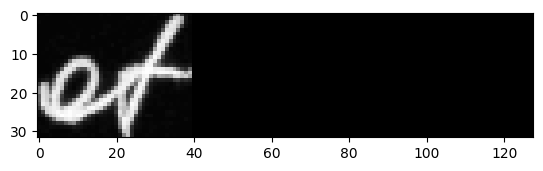



original_text =   Kumasi
predicted text = Kumasi

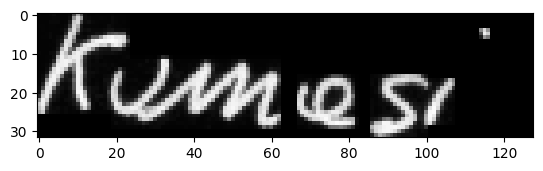



original_text =   where
predicted text = where

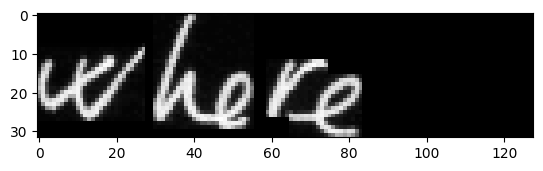



original_text =   the
predicted text = the

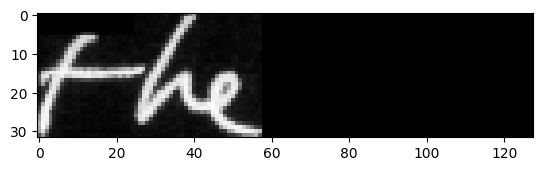



original_text =   police
predicted text = police

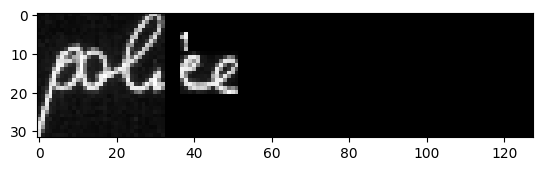



original_text =   and
predicted text = and

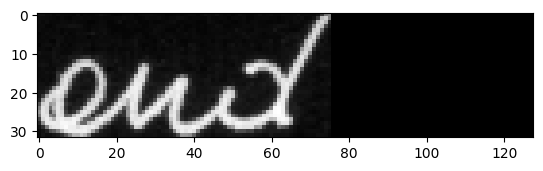



original_text =   16
predicted text = 16

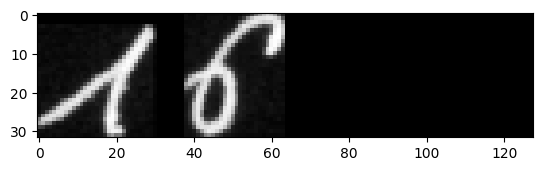



original_text =   armoured
predicted text = armoured

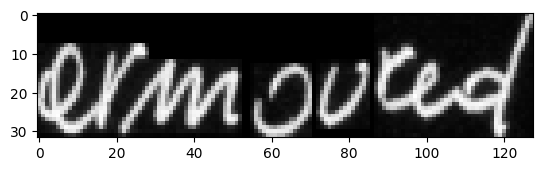



original_text =   cars
predicted text = cars

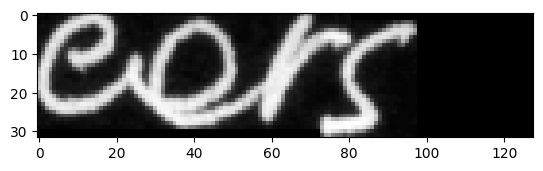



original_text =   .
predicted text = .

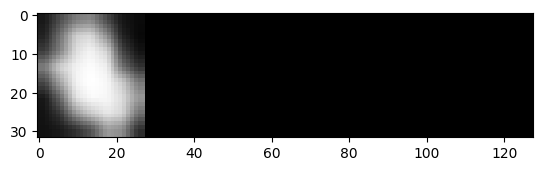



original_text =   And
predicted text = And

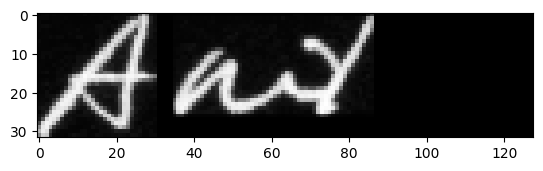



original_text =   did
predicted text = did

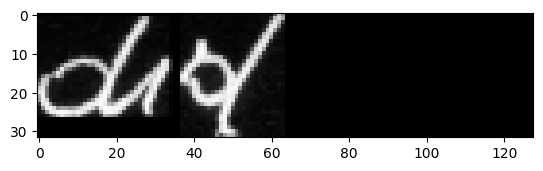



original_text =   the
predicted text = the

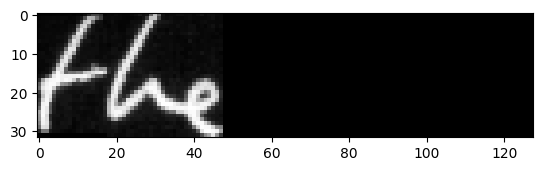



original_text =   Government
predicted text = Government

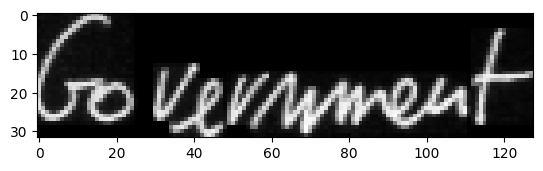



original_text =   react
predicted text = react

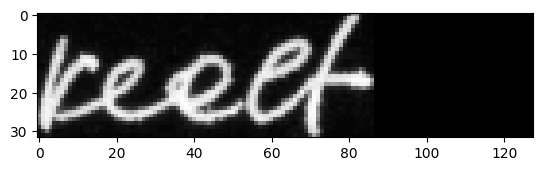



original_text =   when
predicted text = when

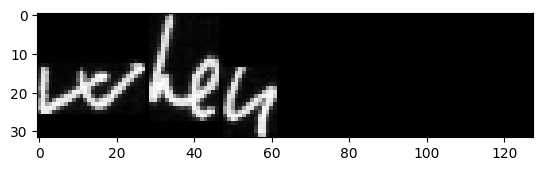



original_text =   the
predicted text = the

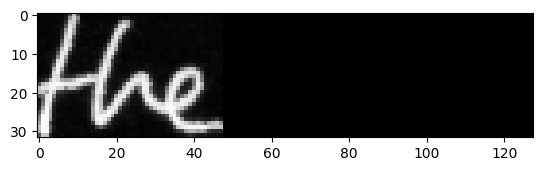



original_text =   strikers
predicted text = strikers

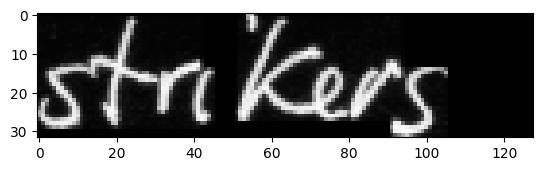



original_text =   demonstrated
predicted text = demonstrated

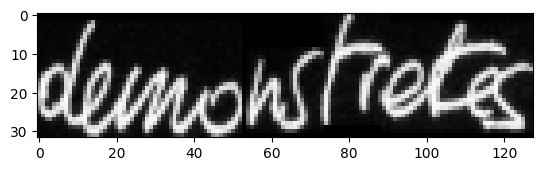



original_text =   in
predicted text = in

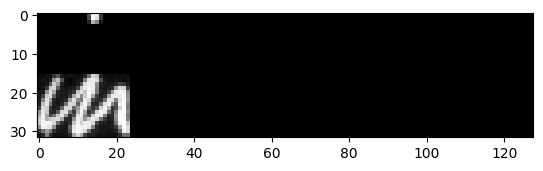



original_text =   ?
predicted text = ?

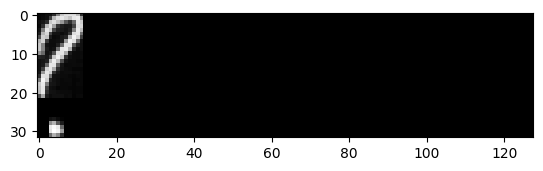



original_text =   bably
predicted text = bably

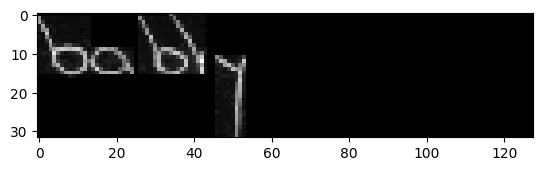



original_text =   the
predicted text = the

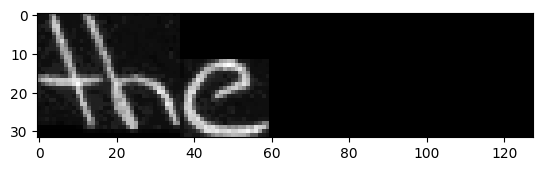



original_text =   toughest
predicted text = toughest

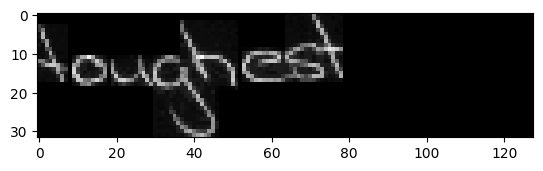



original_text =   man
predicted text = man

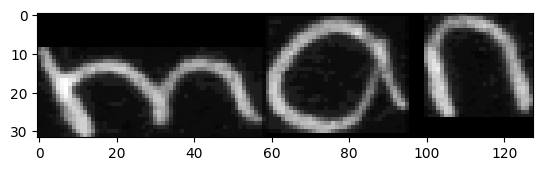



original_text =   in
predicted text = in

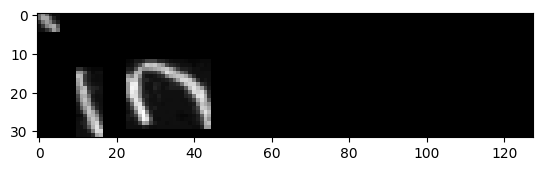



original_text =   Mr.
predicted text = Mr.

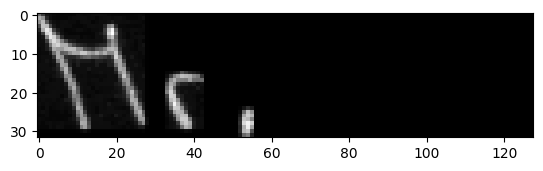



original_text =   Nkrumah's
predicted text = Nkrumah's

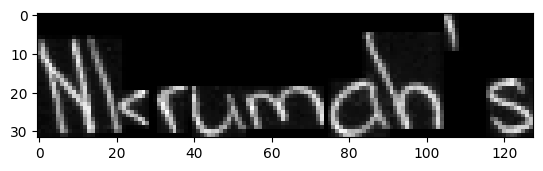



original_text =   team
predicted text = team

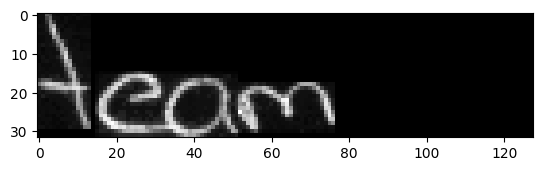



original_text =   drove
predicted text = drove

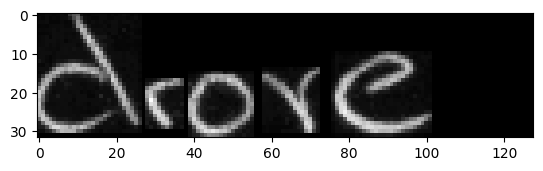



original_text =   up
predicted text = up

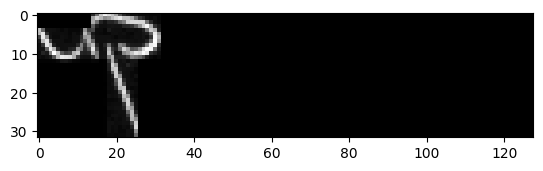



original_text =   to
predicted text = to

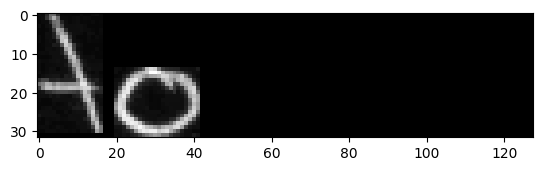



original_text =   the
predicted text = the

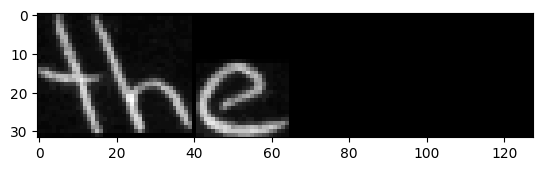



original_text =   Kingsway
predicted text = Kingsway

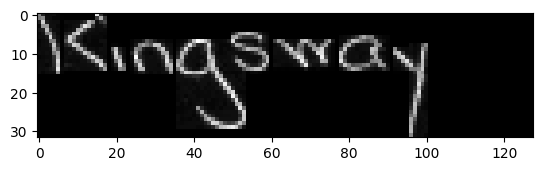



original_text =   Stores
predicted text = Stores

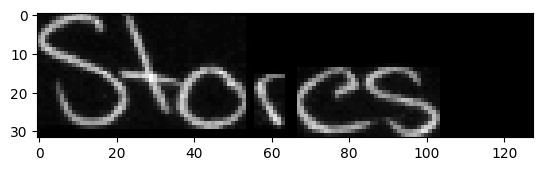



original_text =   and
predicted text = and

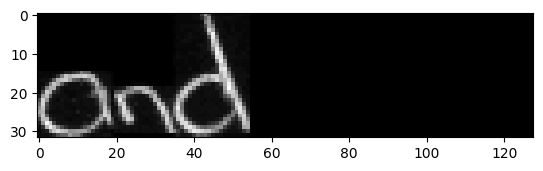



original_text =   faced
predicted text = faced

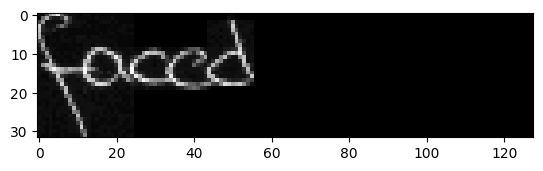



original_text =   the
predicted text = the

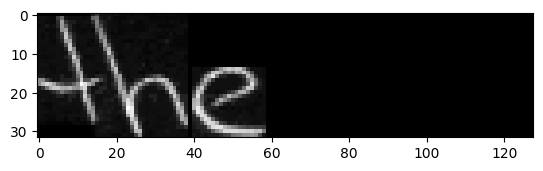



original_text =   ,
predicted text = ,

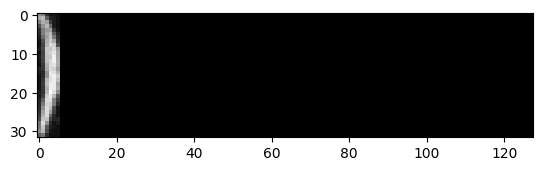



original_text =   most
predicted text = most

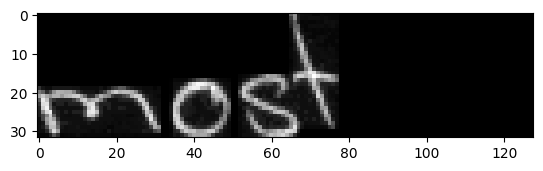

In [77]:
start_index = min(542, len(train_images) - 1)
end_index = min(645, len(train_images))

# If the slice is valid, proceed with prediction
if start_index < end_index:
    prediction = act_model.predict(train_images[start_index:end_index])

    # ... (rest of your code for decoding and displaying results) ...
else:
    print("Invalid slice: The specified range is outside the bounds of train_images.")

# use CTC decoder
decoded = tf.keras.backend.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = tf.keras.backend.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[start_index+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[start_index+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [74]:
loss, accuracy = model.evaluate(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)), verbose=0)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.9991850256919861
